## Astronomy 406 "Computational Astrophysics" (Fall 2017)

# Final Project: Classifying the Disk Structure of Intermediate-Mass Pre-Main Sequence Stars with Machine Learning

## By Adam Rubinstein

### Introduction

Pre-main sequence (PMS) stars are young stars that have not yet fused Hydrogen. They are slowly contracting to the main sequence, surrounded by disks of dust and gas that flattened as these stars collapse. Often, low-mass PMS stars have been used to understand planet formation within these "protoplanetary" disks. 

Meanwhile, the sample of more massive (~2 -- 8 Msun) PMS stars are not as well sampled and are thus more difficult to study. Such PMS stars, known as Herbig Ae/Be (HAeBe) stars are, therefore, a good sample to test whether or not the signposts of planet formation or predictions of planet formation based on the low-mass PMS star disks also apply around higher-mass PMS stars. 

Various low-mass stars, and some HAeBe stars, have been shown to have gaps, which are suggested to be carved out by planets. For HAeBe stars, it was recently found (in 2013, 2015, and 2017) that disk structure (e.g. Flared/puffy or flattened geometry) determines whether a given disk will harbor a gap and possibly forming planets. Specifically, "all" protoplanetary disks are flared, not flat.

Studies usually classify disk structures from detailed models of spectral energy distributions (SEDs) of a few objects (often < ~30). That is to say, the excess emission produced by disks at NIR wavelengths or longer may be used to infer a gap or differentiate between flared and flat disks. Unfortunately, it is difficult to model SEDs of a larger population as these fitting these models can take long to calculate (on the order of months).

### Primary Goals

$\textit{Classifying the disk structure of the population of HAeBe will find target stars for future modeling.}$

$\textit{In turn, further modeling will show how planet formation, if at all, relates to disk structure.}$

$\textit{Finally, a robust classification of HAeBes may inform surveys looking to increase the known HAeBe population, perhaps with protoplanetary disks.}$

### Prior Work

In the past, the steps I took were:

1) Noted established HAeBe stars from publications (e.g. Herbst et al. 1999) 

2) Collected associated data (RA, Dec, Distance, multi-wavelength photometry).

3) Computed colors. Colors are magnitudes that are subtracted and logged. Effectively, this means colors are slopes for a spectrum (a plot of flux vs. wavelength). Very loosely, this gives information about SEDs and their excesses.

4) Used these colors to create color-color diagrams (below is an example JHK diagram). 

5) Classified diagrams by eye to see if disks could be split in excess into flared and flat disks. Respectively, they are expected to have larger (more positive) and smaller (less positive) excesses.

<img src="2MASSJHK001.jpg",width=600,height=600>

Problems:

-The sample comes from various sources and can be hard to narrow down.

-Splitting the groups by eye can be relatively arbitrary. Also, using multi-wavelength colors means there are many combinations. Working in a complicated space of data can lead to many ways of classifying the data.

### Present Study

Taking the data set of colors for various disks, various classification schemes were tested. These come from methods of machine learning, including Gaussian Mixture Modeling, Nearest Neighbors, and Support Vector Machine. When possible, this was tested both with unsupervised and superivsed methods, and as much data as possible was used to make the classifiers more robust.

In [1]:
#Importing useful modules
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, svm, ensemble

In [2]:
#Importing some extra modules
import math
from numpy import nan
import pandas as pd

from astroML.datasets import fetch_sdss_specgals
from astroML.plotting import scatter_contour
from astroML.plotting.tools import draw_ellipse

The following code is to set up for importing the data, finding specific columns of data

In [3]:
#Arrays of photometric bands to read from CSV file of photometry data
optical_arr = ['U', 'B', 'V', 'R', 'I']
JHK_arr = ['J', 'H', 'K']
WISE_arr = ['W1', 'W2', 'W3', 'W4']
SPITZER_arr = ['IRAC_8','IRAS_12','IRS_16','MIPS_24']
IRAS_arr = ['25', '60', '100']
AKARI_arr = ['F9','F18','F65','F90','F140','F160']

#To make array of wavelengths for radio fluxes (it comes from ~20 sources so difficult to type all columns, but luckily it's all in Jy)
with open('MAIN_DATA.csv', 'rb') as csvfile:
    mycsv = pd.read_csv(csvfile)
    myList = list(mycsv.columns.values)
ind1 = myList.index('F160_FLAG')+1
ind2 = myList.index('MEEUS_GRP')-1
myList = myList[ind1:ind2]

radio_arr = myList
radio_arr = ['70'] + [x for x in radio_arr if x.find('REF') == -1]

#For reading in columns of reddening associated with data
reddenOPT_arr = ['A_U', 'A_B', 'A_V', 'A_R', 'A_I']
redden2MASS_arr = ['A_J', 'A_H', 'A_K']
reddenWISE_arr = ['A_W1', 'A_W2', 'A_W3', 'A_W4']

Next, a function that searches my data file and processes the data. The data includes photometry, which needs to be dereddened to work with. All emission we see from stars (and disks) passes through dust, which makes those fluxes appear redder.

In [4]:
#function to get, deredden data from CSV file using pandas
def dataGetter(x_obj):
    mag_list = []

    #opening file
    with open('MAIN_DATA.csv', 'rb') as csvfile:
        mycsv = pd.read_csv(csvfile) #csv reader with pandas

        #the function for each photometric band has a flag check if necessary, dereddens if necessary, and adds to list of magnitudes or fluxes for available photometry in CSV file

        #optical magnitudes
        for i in xrange(0, len(optical_arr)):
            mag_list.append(float(mycsv[optical_arr[i]][x_obj]) - float(mycsv[reddenOPT_arr[i]][x_obj]))

        #2MASS magnitudes
        spot = mycsv['2MASS_FLAG'][x_obj]
        for i in xrange(0, len(JHK_arr)):
            if spot[i] == ('0' or 'H'):
                mag_list.append(float(mycsv[JHK_arr[i]][x_obj]) - float(mycsv[redden2MASS_arr[i]][x_obj]))
            else: 
                mag_list.append(float(nan))
        
        #WISE magnitudes
        spot = mycsv['WISE_FLAG'][x_obj]
        for i in xrange(0, len(WISE_arr)):            
            if spot[i] == ('0' or 'H'):
                mag_list.append(float(mycsv[WISE_arr[i]][x_obj]) - float(mycsv[reddenWISE_arr[i]][x_obj]))
            else:
                mag_list.append(float(nan))

        #Spitzer fluxes
        for i in xrange(0, len(SPITZER_arr)):
            try:
                 mag_list.append(float(mycsv[SPITZER_arr[i]][x_obj]))
            except ValueError:
                mag_list.append(float(nan))

        #AKARI PSC and BSC fluxes
        for i in xrange(0, len(AKARI_arr)):
            if mycsv[AKARI_arr[i] + '_FLAG'][x_obj] == '3':
                mag_list.append(float(mycsv[AKARI_arr[i]][x_obj]))
            else:
                mag_list.append(float(nan))

        #IRAS fluxes
        for i in xrange(0, len(IRAS_arr)):
            if mycsv['F'+IRAS_arr[i]+'_FLAG'][x_obj] == ('2') or mycsv['F'+IRAS_arr[i]+'_FLAG'][x_obj] == ('3'):
                mag_list.append(float(mycsv['IRAS_'+IRAS_arr[i]][x_obj]))
            else:
                mag_list.append(float(nan))

        #radio magnitudes
        for i in xrange(0, len(radio_arr)):
            spot = mycsv[radio_arr[i]][x_obj]
            mag_list.append(float(spot))

    #some other data of interest (identifier, spectral type, and distance for stars)
    mag_list.append(mycsv['MAIN_ID'][x_obj])
    mag_list.append(mycsv['SP_TYPE'][x_obj])
    mag_list.append(mycsv['DIST(pc)'][x_obj])
    mag_list.append(mycsv['A_V'][x_obj])
    mag_list.append(mycsv['Mdot'][x_obj])
    mag_list.append(mycsv['Inclination'][x_obj])
    return mag_list


Putting the data into a list for all stars from the data file using the function

In [5]:
star_dat = []

for z in range(179):
    #using function call to output data needed
    star_dat.append(dataGetter(z))
        
        #Data obtained: 
        #optical_dat= [float(i) for i in arr[0:5]] #[U,B,V,R,I]
        #JHK_dat= [float(i) for i in arr[5:8]] #[J,H,K] 
        #WISE_dat= [float(i) for i in arr[8:12]] #[w1,w2,w3,w4]
        #SPITZER_dat= [float(i) for i in arr[12:16]] #[irac_8,iras_12,irs_16,mips_24]
        #AKARI_dat= [float(i) for i in arr[16:22]] #[f9,f18,f65,f90,f140,f160]
        #radio_dat= [float(i) for i in arr[22:-4]]
        #identifier = arr[-4].upper()
        #sptype = arr[-3]
        #dist = arr[-2]
        #A_V = str(arr[-1])

# Plotting all data
This is to inspect the full data set

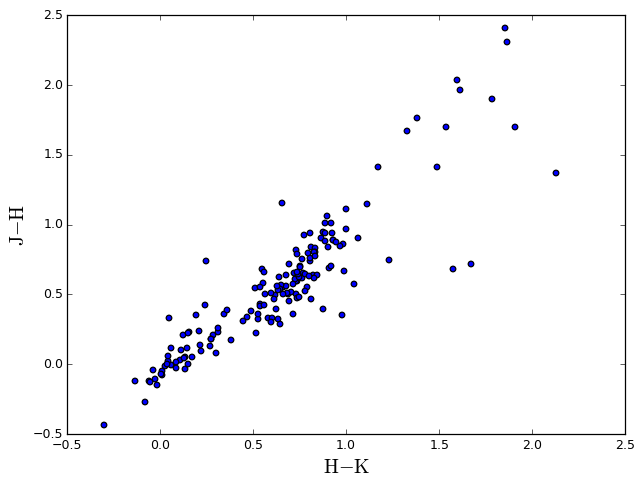

In [6]:
JH_orig = []
HK_orig = []

for star in star_dat:
    HK_orig.append(star[6] - star[7])
    JH_orig.append(star[5] - star[6])

X = np.vstack([HK_orig, JH_orig]).T


fig, ax = plt.subplots(figsize=(8, 6))
#scatter_contour(HK, JH, threshold=400, log_counts=True, ax=ax,
#                histogram2d_args=dict(bins=100),
#                plot_args=dict(marker=',', linestyle='none', color='black'),
#                contour_args=dict(cmap=plt.cm.bone))
ax.scatter(HK_orig, JH_orig)
ax.set_xlabel(r'${\rm H - K}$', size=16)
ax.set_ylabel(r'${\rm J - H}$', size=16)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 2.5)
plt.show()



<img src="2MASSJHK001.jpg",style="float: left;",width=500,height=500> 

## Restricting the data set

So there are outliers!

Disks of interest that form planets should have JHK excess > 0 but also shouldn't have too much excess (e.g. excess ~ 2). The latter implies a star/disk enshrouded in dust, which makes the object extremely red (dubbed "Class I objects). Such objects are too young, and we can't truly see disks. Signs of planet formation may be confused with excess due to the envelope.

Additionally, excesses < 0 imply a "naked" object or an object that was incorrectly dereddened (making the data either inaccurate or not applicable to our search for protoplanetary disks).

The sample is, therefore, restricted from 0 to ~1.3 as a result. 

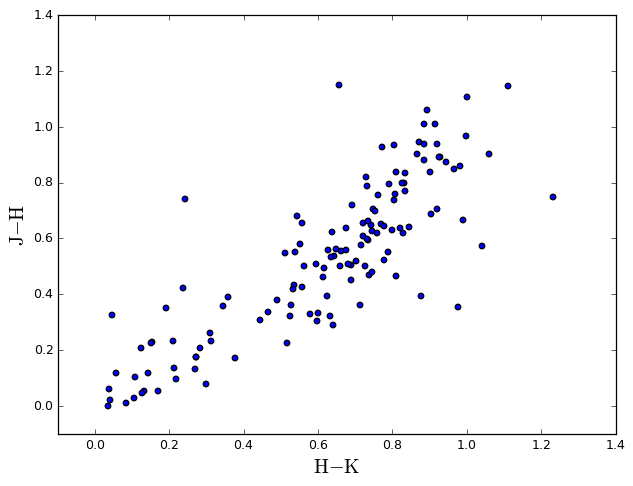

In [7]:
#This function deletes nans in a given row of an array, returns a list with nans deleted
#This was used because sklearn could not work with nans
def nan_delete(dat_arr):
    count = 0
    for i in dat_arr:
        if np.isnan(i).any() == True:
            dat_arr = np.delete(dat_arr, count, axis = 0)
            count -= 1

        count += 1  
    return dat_arr

#This function restricts data to a certain range by replacing rows with nans
def dat_nan(dat_arr, upper=1.4, lower=0, nan_len = 2):
    count = 0
    for i in dat_arr:
        if (i[0] > upper or i[0] < lower) or (i[1] > upper or i[1] < lower):
            dat_arr[count] = [float(nan)]*nan_len
        count += 1  
    return dat_arr    

#Testing the functions, and eliminating nans (without eliminating outliers)
X_nantest = nan_delete(X)

#Applying the functions (labeling outliers as nans, eliminating all nans)
X_nan = dat_nan(X, upper=1.4, lower=0, nan_len=len(X[0]))
X_cut = nan_delete(X_nan)
HK = X_cut[:,0]
JH = X_cut[:,1]



fig, ax = plt.subplots(figsize=(8, 6))
#scatter_contour(HK, JH, threshold=400, log_counts=True, ax=ax,
#                histogram2d_args=dict(bins=100),
#                plot_args=dict(marker=',', linestyle='none', color='black'),
#                contour_args=dict(cmap=plt.cm.bone))
ax.scatter(HK, JH)
ax.set_xlabel(r'${\rm H - K}$', size=16)
ax.set_ylabel(r'${\rm J - H}$', size=16)
ax.set_xlim(-0.1, 1.4)
ax.set_ylim(-0.1, 1.4)
plt.show()

Histograms are plotted below to show the groups. In the larger data set some groups may seem "obvious", but a smaller test set makes this distinctly unclear. This smaller set is useful for methods of machine learning.

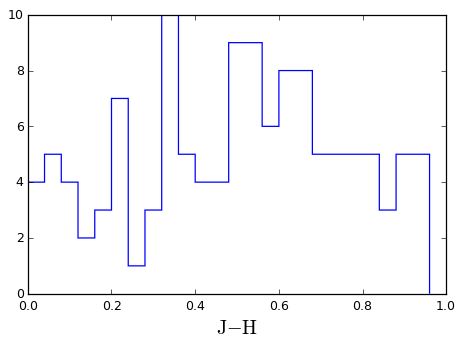

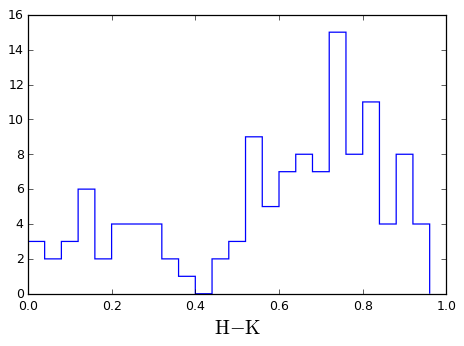

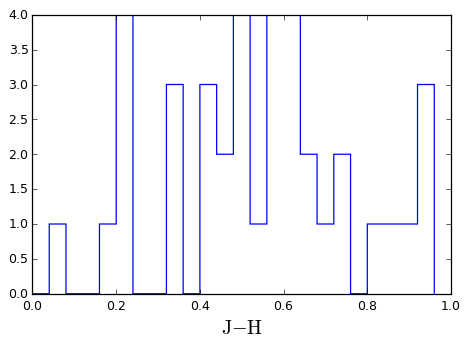

In [8]:
plt.hist(JH, bins=np.arange(0.,1,0.04), histtype='step')
plt.xlabel(r'${\rm J - H}$', size=16)
plt.show()

plt.hist(HK, bins=np.arange(0.,1,0.04), histtype='step')
plt.xlabel(r'${\rm H - K}$', size=16)
plt.show()

plt.hist(JH[:40], bins=np.arange(0.,1,0.04), histtype='step')
plt.xlabel(r'${\rm J - H}$', size=16)
plt.show()

Outputting the test set from the original sample and the restricted sample. The restricted data set is used from now on.

In [9]:
print 'total dataset (original sample):', X_nantest.shape, 'disks'

Xtraining_orig = X_nantest[:35]
print 'training set:', len(Xtraining_orig), 'disks'

Xtest_orig = X_nantest[-100:]
print 'test set:', len(Xtest_orig), 'disks'

total dataset (original sample): (162L, 2L) disks
training set: 35 disks
test set: 100 disks


In [10]:
print 'total dataset (eliminating outliers):', X_cut.shape, 'disks'

Xtraining = X_cut[:35]
print 'training set:', len(Xtraining), 'disks'

Xtest = X_cut[-100:]
print 'test set:', len(Xtest), 'disks'

total dataset (eliminating outliers): (132L, 2L) disks
training set: 35 disks
test set: 100 disks


### Gaussian Mixture Modeling
First, a GMM model is applied as an unsupervised way of grouping stars on the JHK color-color diagram. To determine how many Gaussian distributions underlie the data set, AIC and BIC were tested for varying numbers of Gaussian models.

best fit converged: True
BIC: N components = 1
best fit converged: True
AIC: N components = 3


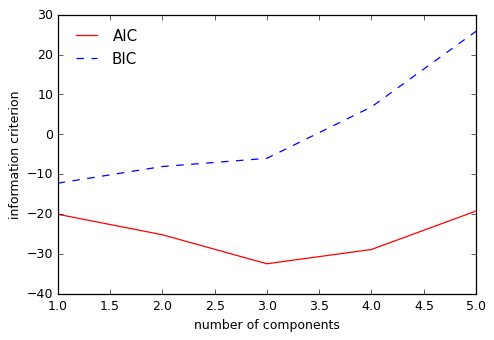

In [11]:
from sklearn.mixture import GMM

N = np.arange(1, 6)
models = [None for n in N]

for i in range(len(N)):
    models[i] = GMM(N[i], covariance_type='full').fit(Xtraining)
AIC = [m.aic(Xtraining) for m in models]
BIC = [m.bic(Xtraining) for m in models]

i_best_bic = np.argmin(BIC)
gmm_best = models[i_best_bic]
print 'best fit converged:', gmm_best.converged_
#print 'number of interations =', gmm_best.n_iter_
print 'BIC: N components = %i' % N[i_best_bic]

i_best_aic = np.argmin(AIC)
gmm_best = models[i_best_aic]
print 'best fit converged:', gmm_best.converged_
#print 'number of interations =', gmm_best.n_iter_
print 'AIC: N components = %i' % N[i_best_aic]

plt.plot(N, AIC, 'r-', label='AIC')
plt.plot(N, BIC, 'b--', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend(loc=2, frameon=False)
plt.show()

Next, the data itself was fit using the appropriate number of models.

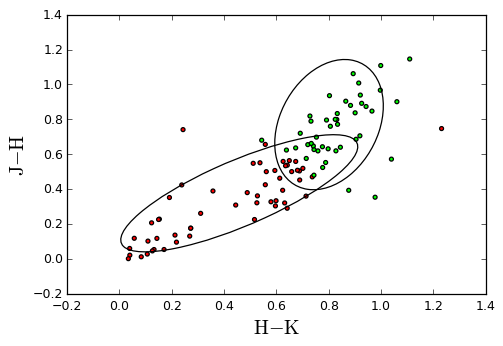

In [12]:
cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000', '#8000FF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])

gmm_best = models[N[int(np.mean([i_best_aic, i_best_bic]))] - 1]

plt.scatter(Xtest[:,0], Xtest[:,1], c=gmm_best.predict(Xtest), cmap=cmap_bold, alpha=1, s=10)

#plt.scatter(Xtest_cut[:,0], Xtest_cut[:,1], c=gmm_best.predict(Xtest_cut), cmap=cmap_bold, alpha=0.7, s=10)
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)

for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[2], fc='none', ec='k')

<img src="2MASSJHK001.jpg",style="float: left;",width=500,height=500> 

Finally, a contour plot was used to predict the split in the groupings based on GMM in the entire JHK space.

[]

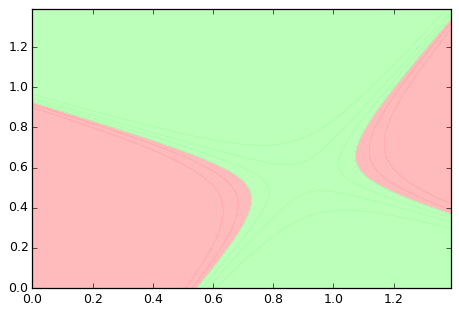

In [13]:
xx, yy = np.meshgrid(np.arange(0,1.4,0.01), np.arange(0,1.4,0.01))

Z = gmm_best.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light)
plt.plot()

### It seems...

Not bad! Compared to the classification by eye it comes up with something slightly different. It also suggests all of these objects are within one to three groups. This makes sense as these objects should either all be HAeBes, be two sub-groups of HAeBes, or perhaps have some mixed group as a third group. 

Now to try labeling the data by KNN.

# Next: Nearest Neighbor
First, defining a separation within the group by eye

In [14]:
border = 0.45
target = (Xtraining[:,0] > border)

[]

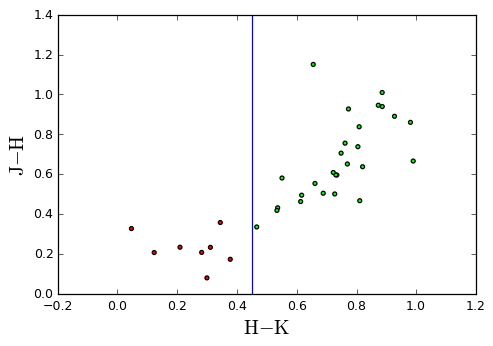

In [15]:
#cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])
#cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA'])


plt.scatter(Xtraining[:,0], Xtraining[:,1], c=target, cmap=cmap_bold, alpha=1., s=10)
plt.axvline(border)
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)
plt.plot()

Now, applying KNN to color the validation set based on a training set.

[]

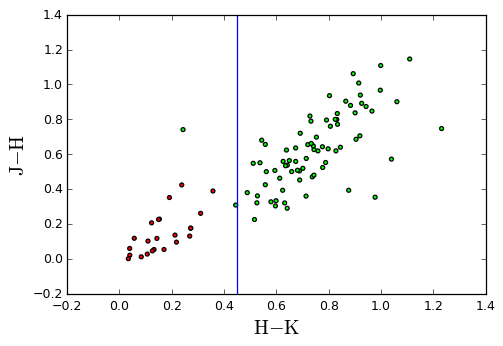

In [16]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=1., s=10)
plt.axvline(border)
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)
plt.plot()

<img src="2MASSJHK001.jpg",style="float: left;",width=500,height=500> 

As with GMM, now creating a color map based on KNN.

[]

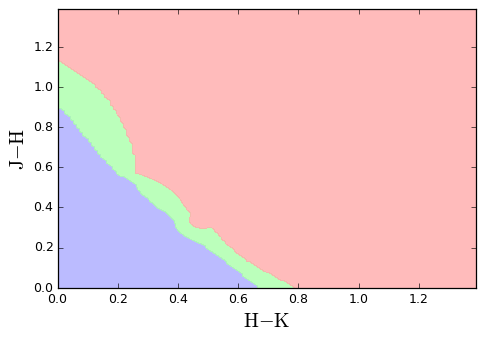

In [17]:
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)
plt.plot()

# Testing SVC for Comparison

So far:
-GMM split the data into two groups (with a lot of overlap)

-KNN split the data into two groups (with a thin strip of overlap)

SVC / SVM focuses on clustering of data and what surrounds those clusters, so it is also a good option to test after these initial tries at classifying the data.

[]

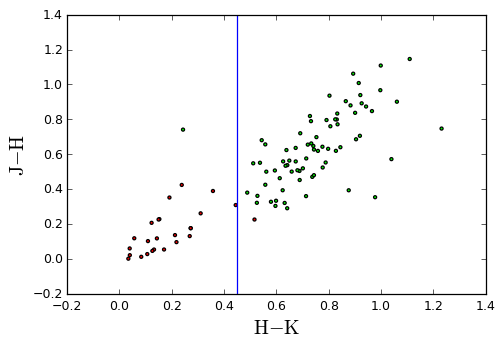

In [18]:
#clf = svm.SVC(gamma=2, kernel='linear')
clf = svm.SVC(gamma=2, kernel='rbf')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=1., s=6)
plt.axvline(border)
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)
plt.plot()

<img src="2MASSJHK001.jpg",style="float: left;",width=500,height=500> 

[]

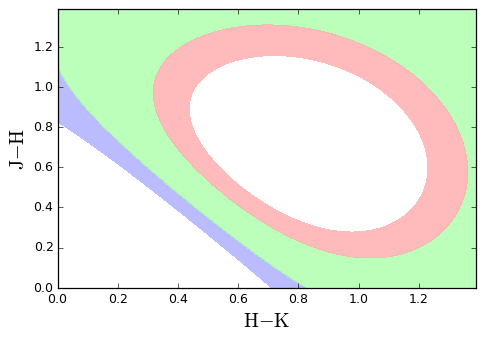

In [19]:
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)
plt.plot()

Interesting! We again have ~2 groups, but one is a central cluster and the other is more spread out. It also seems as this does not capture the "Hernandez" group from the initial diagram.

It seems as though GMM makes groups overlap too much, while SVC is close but still not reflective of the initial groupings.

# Adding More Information (Colors)

Now to add the information that we hadn't used before for our classification (all combinations of JHK, and the four WISE passbands). Trying KNN to see if anything changes as the other methods did worse at recovering the initial classifiers in the introductory diagram.

In [20]:
JH_orig = []
HK_orig = []
W1W4_orig = []
W2W4_orig = []
W3W4_orig = []  
JW1_orig = []
JW2_orig = []
JW3_orig = []
JW4_orig = []
ids = []

for star in star_dat:
    HK_orig.append(star[6] - star[7])
    JH_orig.append(star[5] - star[6])
    #WISE = W1, W2, W3, W4 (8, 9, 10, 11)
    W1W4_orig.append(star[8] - star[11])
    W2W4_orig.append(star[9] - star[11])
    W3W4_orig.append(star[10] - star[11])     
    JW1_orig.append(star[5] - star[8])
    JW2_orig.append(star[5] - star[9])
    JW3_orig.append(star[5] - star[10])
    JW4_orig.append(star[5] - star[11])
    ids.append(star[-6])
    

X = np.vstack([HK_orig, JH_orig, W1W4_orig, W2W4_orig, W3W4_orig, JW1_orig, JW2_orig, JW3_orig, JW4_orig]).T

#print np.vstack([X[:,0], ids]).T

#Testing the functions, and eliminating nans (without eliminating outliers)
X_nantest = nan_delete(X)

#Applying the functions (labeling outliers as nans, eliminating all nans)
X_nan = dat_nan(X, upper=1.4, lower=0, nan_len=len(X[0]))
X_cut = nan_delete(X_nan)
HK = X_cut[:,0]
JH = X_cut[:,1]

In [21]:
print 'total dataset:', X_cut.shape, 'disks'

Xtraining = X_cut[:15]
print 'training set:', len(Xtraining), 'disks'

Xtest = X_cut[-35:]
print 'test set:', len(Xtest), 'disks'

total dataset: (51L, 9L) disks
training set: 15 disks
test set: 35 disks


In [22]:
border = 0.45
target = (Xtraining[:,0] > border)

[]

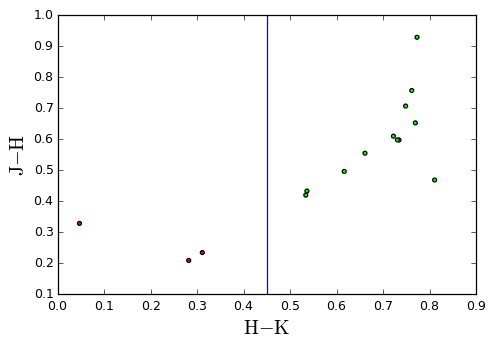

In [23]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
#cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA'])


plt.scatter(Xtraining[:,0], Xtraining[:,1], c=target, cmap=cmap_bold, alpha=1., s=10)
plt.axvline(border)
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)
plt.plot()

[]

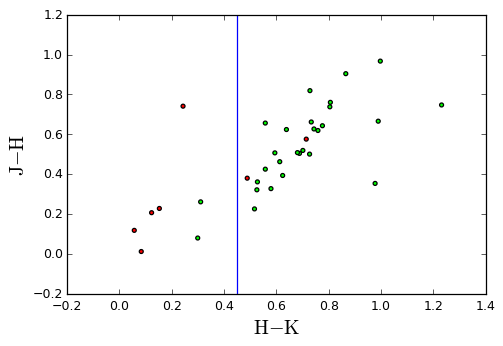

In [24]:
clf = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

#data = np.vstack([Xtest[:,0], y]).T
#data=data[np.argsort(data[:,0])]
#print data

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=1., s=10)
plt.axvline(border)
#plt.xlim(18,14)
#plt.ylim(0,1.2)
plt.xlabel(r'${\rm H - K}$', size=16)
plt.ylabel(r'${\rm J - H}$', size=16)
plt.plot()

<img src="2MASSJHK001.jpg",style="float: left;",width=500,height=500> 

## Final Thoughts

KNN was preferred for identifying the groups. It was the best at recovering the original groupings compared with the other methods (GMM, SVC). This also makes some sense with GMM as the data may not be underlied by Gaussians.

Adding data also showed aspects that the JHK diagram by itself did not show. Namely that the original classification was binary, but adding data better shows the overlap between the groups. This would have been unexpected before, but now this can be predicted! Unfortunately, the sample is small, likely because many stars have flagged WISE data.

This doesn't *directly* show the differences in structure, but inspecting these sources could show differences that are not obvious from comparing two colors at a time was done before!